In [1]:
# Standard library
import json
import os
from collections import Counter, defaultdict
from collections.abc import Callable
from hashlib import sha256
from pathlib import Path
from typing import Any, Never

import matplotlib.pyplot as plt

# Third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import PercentFormatter
from networkx import DiGraph
from rich.console import Console
from rich.progress import track

from ariel.body_phenotypes.robogen_lite.config import (
    NUM_OF_FACES,
    NUM_OF_ROTATIONS,
    NUM_OF_TYPES_OF_MODULES,
)
from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel.body_phenotypes.robogen_lite.decoders.visualize_tree import (
    visualize_tree_from_graph,
)

# Local libraries
from ariel.body_phenotypes.robogen_lite.modules.brick import BRICK_MASS
from ariel.body_phenotypes.robogen_lite.modules.core import CORE_MASS
from ariel.body_phenotypes.robogen_lite.modules.hinge import (
    ROTOR_MASS,
    STATOR_MASS,
)

console = Console()

In [2]:
# Global constants
SCRIPT_NAME = "Initial"
CWD = Path.cwd()
DATA = Path(CWD / "__data__" / SCRIPT_NAME)
DATA.mkdir(exist_ok=True)
SEED = 40

# Global functions
console = Console()
RNG = np.random.default_rng(SEED)


In [3]:
def generate_body(num_modules: int = 20) -> DiGraph:
    """Generate random robot with HighProbabilityDecoder."""
    # System parameters

    # "Type" probability space
    type_probability_space = RNG.random(
        size=(num_modules, NUM_OF_TYPES_OF_MODULES),
        dtype=np.float32,
    )

    # "Connection" probability space
    conn_probability_space = RNG.random(
        size=(num_modules, num_modules, NUM_OF_FACES),
        dtype=np.float32,
    )

    # "Rotation" probability space
    rotation_probability_space = RNG.random(
        size=(num_modules, NUM_OF_ROTATIONS),
        dtype=np.float32,
    )

    # Decode the high-probability graph
    hpd = HighProbabilityDecoder(num_modules)
    hpd.probability_matrices_to_graph(
        type_probability_space,
        conn_probability_space,
        rotation_probability_space,
    )

    # Decode the high-probability graph
    hpd = HighProbabilityDecoder(num_modules)
    return hpd.probability_matrices_to_graph(
        type_probability_space,
        conn_probability_space,
        rotation_probability_space,
    )

In [4]:
# def run(
#     robot: CoreModule,
#     *,
#     with_viewer: bool = False,
# ) -> None:
#     """Entry point."""
#     # MuJoCo configuration
#     viz_options = mujoco.MjvOption()  # visualization of various elements

#     # Visualization of the corresponding model or decoration element
#     viz_options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
#     viz_options.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
#     viz_options.flags[mujoco.mjtVisFlag.mjVIS_BODYBVH] = True

#     # MuJoCo basics
#     world = TiltedFlatWorld()

#     # Set random colors for geoms
#     for i in range(len(robot.spec.geoms)):
#         robot.spec.geoms[i].rgba[-1] = 0.5

#     # Spawn the robot at the world
#     world.spawn(robot.spec)

#     # Compile the model
#     model = world.spec.compile()
#     data = mujoco.MjData(model)

#     # Save the model to XML
#     xml = world.spec.to_xml()
#     with (DATA / f"{SCRIPT_NAME}.xml").open("w", encoding="utf-8") as f:
#         f.write(xml)

#     # Number of actuators and DoFs
#     console.log(f"DoF (model.nv): {model.nv}, Actuators (model.nu): {model.nu}")

#     # Reset state and time of simulation
#     mujoco.mj_resetData(model, data)

#     # Render
#     # single_frame_renderer(model, data, steps=10)

#     # View
#     if with_viewer:
#         viewer.launch(model=model, data=data)

In [5]:
# delta = 10000  # just a random nr that bigger than 0.1
# diversity = 0
# nr_of_blocks = []
# old_avg_b = 0
# old_avg_h = 0
# nr_of_hinges = []
# learnability = 0  # maybe later
# graph_list = []
# while delta > 0.00001:
#     graph = generate_body()
#     graph_list.append(graph)
#     graph = dict(graph.nodes)
#     hinges = sum(graph[node]["type"] == "HINGE" for node in graph)
#     blocks = sum(graph[node]["type"] == "BRICK" for node in graph)
#     nr_of_blocks.append(blocks)
#     nr_of_hinges.append(hinges)

#     # skip the first 100
#     if len(nr_of_blocks) < 100:
#         continue

#     # go until we broke
#     new_avg_b = np.average(nr_of_blocks)
#     new_avg_h = np.average(nr_of_hinges)
#     delta = max(abs(old_avg_b - new_avg_b), abs(old_avg_h - new_avg_h))

#     if len(graph_list) >= 100_000:
#         break

#     old_avg_b = new_avg_b
#     old_avg_h = new_avg_h

# print(
#     f"Done!\nEnded with a delta of {max(abs(old_avg_b - new_avg_b), abs(old_avg_h - new_avg_h))}\nThe avg nr of blocks are: {new_avg_b}\nThe avg nr of hinges is: {new_avg_h}\nConcluded after {len(graph_list)} generated robots!"
# )


---

### Functions for analysis on individual

In [6]:
def analyze_module_counts(individual: DiGraph) -> dict[str, int]:
    counts: dict[str, int] = {
        "core": sum(
            data["type"] == "CORE" for _, data in individual.nodes(data=True)
        ),
        "brick": sum(
            data["type"] == "BRICK" for _, data in individual.nodes(data=True)
        ),
        "hinge": sum(
            data["type"] == "HINGE" for _, data in individual.nodes(data=True)
        ),
        "none": sum(
            data["type"] == "NONE" for _, data in individual.nodes(data=True)
        ),
        "edges": len(individual.edges()),
    }
    counts["not-none"] = counts["core"] + counts["brick"] + counts["hinge"]
    assert counts["core"] == 1
    return counts

In [7]:
def analyze_mass(individual: DiGraph) -> dict[str, float]:
    counts = analyze_module_counts(individual)
    core_mass = counts["core"] * CORE_MASS
    brick_tot_mass = counts["brick"] * BRICK_MASS
    hinge_tot_mass = counts["hinge"] * (ROTOR_MASS + STATOR_MASS)
    total_mass = core_mass + brick_tot_mass + hinge_tot_mass
    return {"mass": total_mass}

In [8]:
def analyze_json_hash(individual: DiGraph) -> dict[str, str]:
    """Return a SHA-256 hash of a deterministic representation of the graph."""
    # Collect nodes and edges with attributes, sorted for determinism
    nodes = sorted([(n, dict(individual.nodes[n])) for n in individual.nodes()])
    edges = sorted([
        (u, v, dict(individual.edges[u, v])) for u, v in individual.edges()
    ])
    # Create a canonical dict
    canonical = {"nodes": nodes, "edges": edges}
    # Hash the canonical JSON string
    hash_string = sha256(
        json.dumps(canonical, sort_keys=True).encode("utf-8"),
    ).hexdigest()
    return {"hash": hash_string}

### Parallel running method for individual analysis data

In [9]:
def analyze_individual(
    analyzers: Callable[[DiGraph], dict[str, Any]], num_modules=None,
):
    individual = generate_body(num_modules) if num_modules else generate_body()
    results = {"population": [individual]}
    for analyzer in analyzers:
        results.update(analyzer(individual))
    return results


def analyze_population(
    population_size: int,
    *,
    num_modules: int | None = None,
    analyzers: Callable[[DiGraph], dict[str, Any]] | None = None,
    n_jobs: int = -1,
) -> tuple[dict[str, Any], list[DiGraph]]:
    if analyzers is None:
        analyzers = [analyze_module_counts, analyze_mass, analyze_json_hash]

    if n_jobs != 1:
        raise NotImplementedError

    if n_jobs == -1:
        available_cpus = os.cpu_count()
        if available_cpus is not None and available_cpus > 2:
            n_jobs = available_cpus - 2
        elif available_cpus is not None and available_cpus > 1:
            n_jobs = available_cpus - 1
        else:
            n_jobs = 1

    console.log(f"Using {n_jobs} cpu(s)")
    console.log(f"Starting analysis of {population_size} individuals...")

    # Parallel execution with progress bar
    with Parallel(n_jobs=n_jobs) as parallel:
        results = parallel(
            delayed(analyze_individual)(analyzers)
            for _ in track(
                range(population_size),
                description="Analyzing population",
            )
        )

    properties_dict = defaultdict(list)
    # cast(results, dict)
    for result in results:
        for key, value in result.items():
            properties_dict[key].append(value)

    console.log("Analysis complete.")
    final_dict = dict(properties_dict)
    population = final_dict.pop("population")
    return final_dict, population

### Visualization methods for the analysis on a population

In [10]:
def create_boxplot_from_dict(
    properties_dict: dict[str, Any],
    keys: list[str] | None = None,
) -> None:
    # If no keys provided, plot all except 'population'
    if keys is None:
        keys = list(properties_dict.keys())
    # Prepare data for seaborn
    data = []
    labels = []
    for key in keys:
        if key in properties_dict:
            data.append(properties_dict[key])
            labels.append(key)
    # Create boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.ylabel("Value")
    plt.title("Boxplot of Robot Properties")
    plt.show()

In [12]:
def create_histogram_from_dict(
    properties_dict: dict[str, Any],
    keys: list[str] | None = None,
    bins: int = 30,
) -> None:
    """
    Draw a grouped histogram of the selected keys.
    For string-valued keys (e.g., hashes), plot the distribution of their frequencies (separately).
    For numeric keys, plot all together in one histogram.
    Title is the key names if there are fewer than 3, otherwise "Histogram of Robot Properties".
    """
    if keys is None:
        keys = list(properties_dict.keys())

    valid_keys = [k for k in keys if k in properties_dict]

    # Check if all selected keys are numeric
    if all(isinstance(properties_dict[k][0], (int, float)) for k in valid_keys):
        # Plot all numeric keys together
        data = [properties_dict[k] for k in valid_keys]
        plt.figure(figsize=(10, 6))
        n, bins_, _patches = plt.hist(
            data,
            bins=bins,
            label=valid_keys,
            edgecolor="black",
            linewidth=1.2,
            alpha=0.8,
            histtype="bar",
            rwidth=0.9,
        )
        total = n.sum()
        plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=total))
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.title(
            ", ".join(valid_keys)
            if len(valid_keys) <= 3
            else "Histogram of Robot Properties",
        )
        plt.show()
    else:
        # Plot string-valued keys separately
        for key in valid_keys:
            values = properties_dict[key]
            if not values:
                continue
            plt.figure(figsize=(10, 6))
            if isinstance(values[0], str):
                counts = Counter(values)
                freqs = list(counts.values())
                n, bins_, _patches = plt.hist(
                    freqs,
                    bins=bins,
                    edgecolor="black",
                    linewidth=1.2,
                    alpha=0.8,
                    rwidth=0.9,
                    label=[key],
                    histtype="bar",
                )
                total = n.sum()
                plt.gca().yaxis.set_major_formatter(
                    PercentFormatter(xmax=total),
                )
                plt.xlabel("Genotype frequency")
                plt.ylabel("Number of unique genotypes")
                plt.title(key)
                plt.legend()
                plt.show()

In [13]:
def statistical_df_from_dict(
    properties_dict: dict[str, Any],
    keys: list[str] | None = None,
    save_file: Path | str | None = None,
) -> pd.DataFrame:
    """
    For each key in properties_dict:
      - If numeric: mean, std, median, count, Q1, Q3, outlier indexes, num_outliers, uniques.
      - If non-numeric: key, count, uniques.
    Returns a DataFrame with correct dtypes.
    """
    if keys is None:
        keys = list(properties_dict)

    rows = []
    for key in keys:
        values = properties_dict[key]
        if not values:
            continue
        uniques = len(set(values))
        if isinstance(values[0], (float, int)):
            arr = np.asarray(values, dtype=float)
            mean = arr.mean()
            std = arr.std(ddof=1)
            median = np.median(arr)
            q1 = np.percentile(arr, 25)
            q3 = np.percentile(arr, 75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outlier_indexes = np.where((arr < lower) | (arr > upper))[
                0
            ].tolist()
            row = {
                "key": key,
                "count": len(arr),
                "uniques": int(uniques),
                "mean": float(mean),
                "std": float(std),
                "median": float(median),
                "Q1": float(q1),
                "Q3": float(q3),
                "num_outliers": len(outlier_indexes),
                "outlier_indexes": outlier_indexes,
            }
        else:
            row = {
                "key": key,
                "count": len(values),
                "uniques": int(uniques),
                "mean": None,
                "std": None,
                "median": None,
                "Q1": None,
                "Q3": None,
                "num_outliers": None,
                "outlier_indexes": None,
            }
        rows.append(row)

    df = pd.DataFrame.from_records(rows)
    df = df.set_index("key")

    # Set dtypes explicitly
    df["count"] = df["count"].astype("Int64")
    df["uniques"] = df["uniques"].astype("Int64")
    for col in ["mean", "std", "median", "Q1", "Q3"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["num_outliers"] = df["num_outliers"].astype("Int64")
    df["outlier_indexes"] = df["outlier_indexes"].astype(object)

    if save_file:
        df.to_csv(save_file)

    return df

In [14]:
def count_df_from_list(value_list: list[str]) -> pd.DataFrame:
    """
    Returns a DataFrame with:
      - index: hash value
      - count: number of times the hash appears
      - indexes: list of indexes in the original list where the hash appears.
    """
    index_dict = defaultdict(list)
    for idx, h in enumerate(value_list):
        index_dict[h].append(idx)

    results = []
    for h, idxs in index_dict.items():
        results.append({
            "value": h,
            "count": len(idxs),
            "indexes": idxs,
        })

    df = pd.DataFrame(results)
    return df.set_index("value")

---

### Running the experiment

In [15]:
# set n_jobs = 1 to not use parallelization. MUST be used rn
properties_dict, population = analyze_population(100_000, n_jobs=1)

[23:12:08] Using 1 cpu(s)                                                                          ]8;id=243315;file:///tmp/ipykernel_24650/3962090928.py\3962090928.py]8;;\:]8;id=222501;file:///tmp/ipykernel_24650/3962090928.py#33\33]8;;\

           Starting analysis of 100000 individuals...                                              ]8;id=466110;file:///tmp/ipykernel_24650/3962090928.py\3962090928.py]8;;\:]8;id=754852;file:///tmp/ipykernel_24650/3962090928.py#34\34]8;;\

Output()

[23:13:58] Analysis complete.                                                                      ]8;id=607271;file:///tmp/ipykernel_24650/3962090928.py\3962090928.py]8;;\:]8;id=197252;file:///tmp/ipykernel_24650/3962090928.py#52\52]8;;\

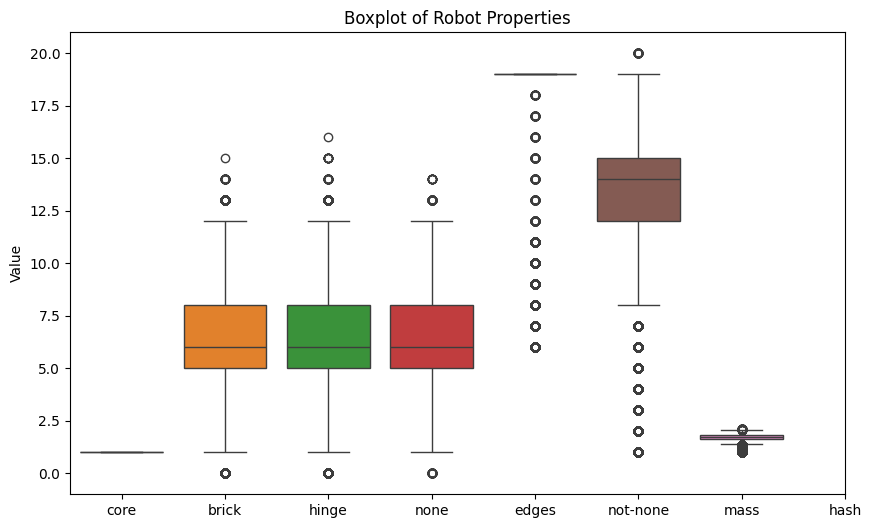

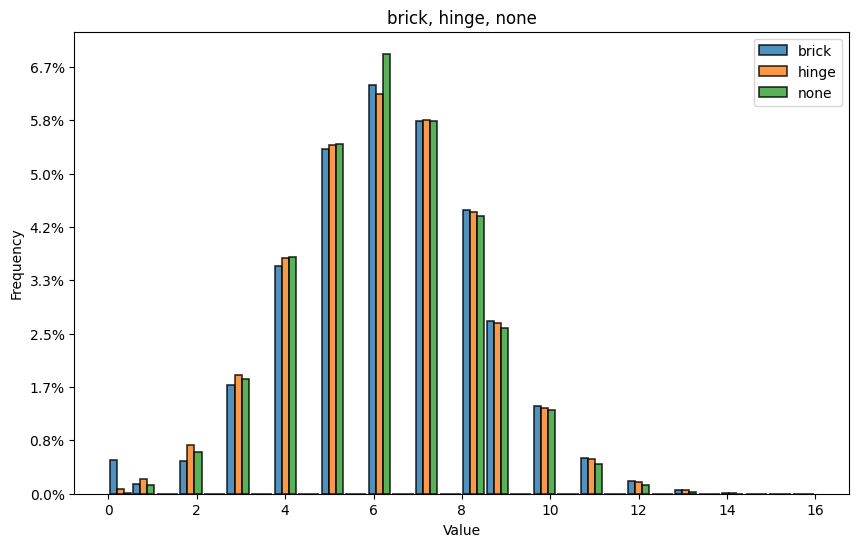

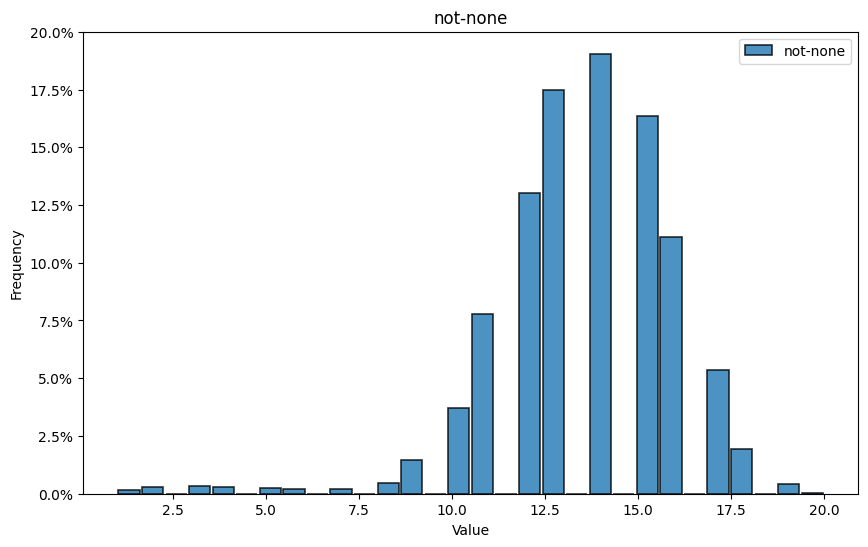

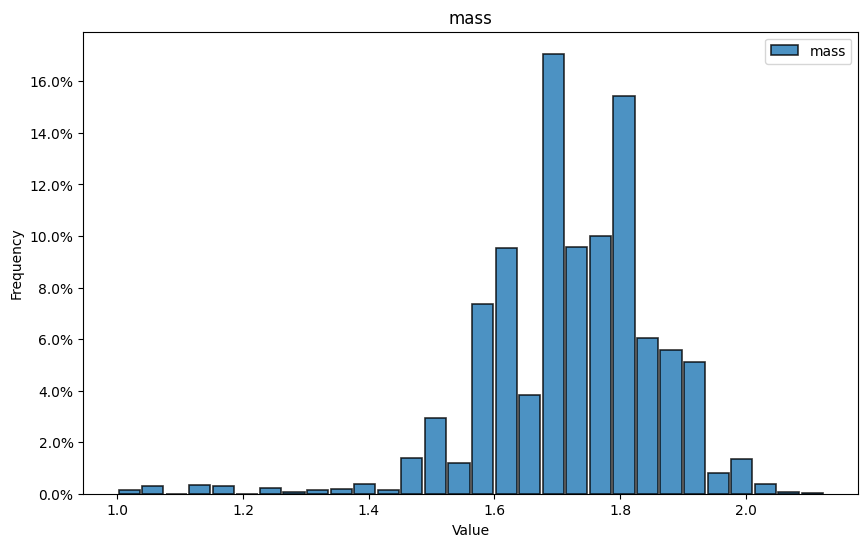

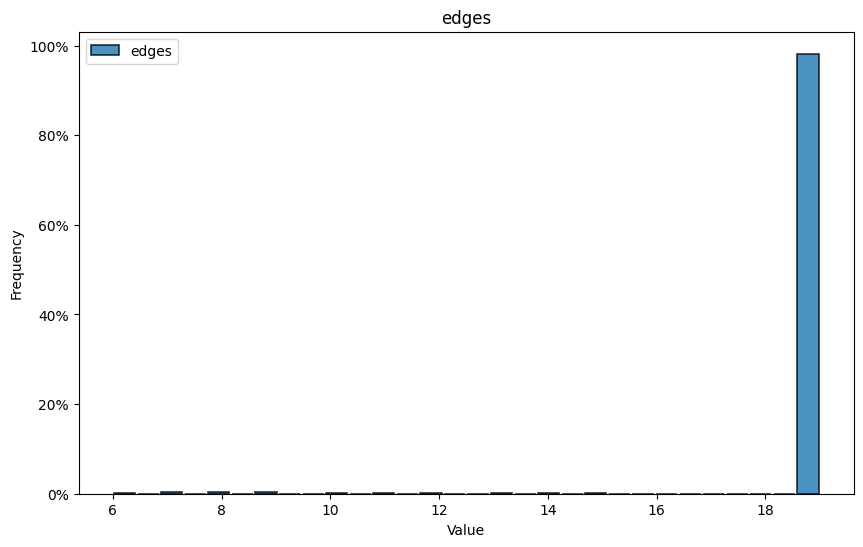

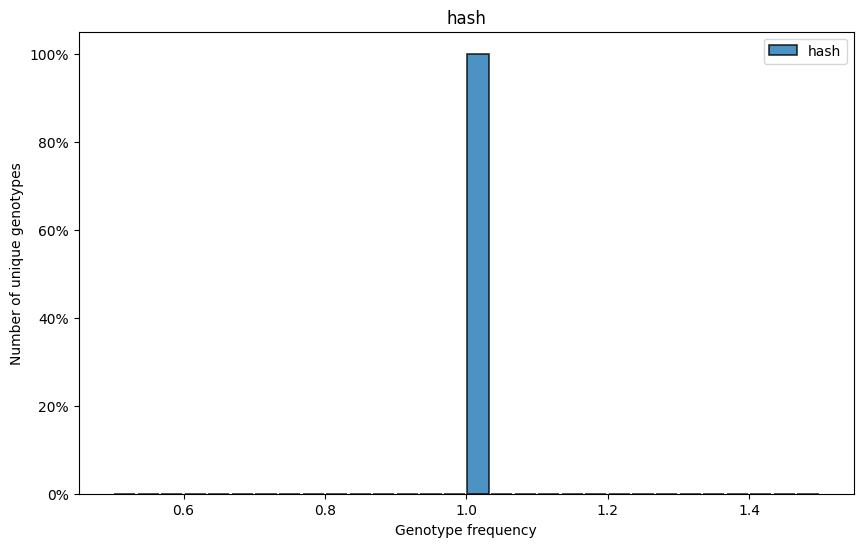

In [16]:
create_boxplot_from_dict(properties_dict)

create_histogram_from_dict(properties_dict, keys=["brick", "hinge", "none"])
create_histogram_from_dict(properties_dict, keys=["not-none"])
create_histogram_from_dict(properties_dict, keys=["mass"])
create_histogram_from_dict(properties_dict, keys=["edges"])
create_histogram_from_dict(properties_dict, keys=["hash"])

In [17]:
stats_df = statistical_df_from_dict(properties_dict)
console.print(stats_df)

console.rule(style="rule.line dim")

# To get the unique counts per property
count_df = count_df_from_list(properties_dict["edges"])
console.print(count_df)

count  uniques       mean       std  median     Q1     Q3  \
key                                                                    
core      100000        1   1.000000  0.000000    1.00   1.00   1.00   
brick     100000       16   6.273800  2.169959    6.00   5.00   8.00   
hinge     100000       17   6.280090  2.103284    6.00   5.00   8.00   
none      100000       15   6.278460  2.003896    6.00   5.00   8.00   
edges     100000       14  18.832350  1.299854   19.00  19.00  19.00   
not-none  100000       20  13.553890  2.383110   14.00  12.00  15.00   
mass      100000      167   1.721864  0.137017    1.74   1.64   1.81   
hash      100000   100000        NaN       NaN     NaN    NaN    NaN   

          num_outliers                                    outlier_indexes  
key                                                                        
core                 0                                                 []  
brick             1771  [93, 151, 169, 245, 332, 335, 393, 458, 473, 6...  
hinge              415  [123, 393, 687, 844, 878, 926, 2118, 2122, 254...  
none               150  [1085, 1603, 2039, 3058, 4175, 5017, 5204, 699...  
edges             1803  [85, 93, 151, 169, 245, 332, 335, 344, 393, 47...  
not-none          1795  [85, 93, 151, 169, 245, 332, 335, 393, 473, 48...  
mass              1795  [85, 93, 151, 169, 245, 332, 335, 393, 473, 48...  
hash              <NA>                                               None

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

count                                            indexes
value                                                          
19     98197  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
14        55  [85, 1173, 2464, 2526, 3389, 7448, 9110, 14958...
9        281  [93, 151, 169, 908, 1465, 2569, 2688, 3166, 35...
7        280  [245, 1056, 1199, 3084, 3307, 3500, 3691, 4276...
11       151  [332, 695, 3374, 4138, 5382, 5503, 6873, 7282,...
8        337  [335, 1149, 1248, 1341, 1545, 2082, 2309, 2497...
17        43  [344, 1876, 3206, 4699, 5131, 7992, 15930, 162...
6        159  [393, 844, 878, 2540, 2782, 3320, 4281, 4356, ...
10       198  [473, 912, 1055, 1430, 1576, 1736, 2530, 2787,...
16        44  [486, 4113, 7524, 15827, 17257, 18177, 18263, ...
15        59  [932, 3275, 4548, 5019, 7313, 7347, 8523, 1219...
12        96  [2731, 3141, 3362, 3889, 6253, 6372, 7949, 906...
18        34  [3136, 11647, 13361, 25026, 25607, 26001, 2720...
13        66  [3877, 6604, 9090, 9530, 9701, 10029, 10112, 1...

---

### Visualize Outliers Interactively

Visualize individuals from a key value dictionary where value contains indexes of the individuals from the population.

In [18]:
class IndividualVisualizer:
    def __init__(
        self,
        index_dict: dict[str, list[int]],
        population: list,
        console=None,
    ) -> None:
        """
        index_dict: dict mapping keys to lists of individual indexes (may be empty).
        population: list of individuals (e.g., DiGraph objects).
        console: rich.console.Console instance for printing (optional).
        """
        self._index_dict = {
            k: v
            for k, v in index_dict.items()
            if isinstance(v, (list, tuple, set))
            and v  # only non-empty lists/tuples/sets
        }
        self._keys = list(self._index_dict.keys())
        self._population = population
        self._key_index = 0
        self._individual_index = 0
        self._direction = 1
        self._console = console or Console()

    def get_count_from_index(self) -> Never:
        """
        Would be cool to select the counts? so switch from main_key to count_key?
        maybe the index_dict is just smart and if it contains a dict, it will createa a sub key selection method??
        """
        raise NotImplementedError

    def select_key(self, index=None) -> None:
        if not self._keys:
            self._console.print("[red]No keys with individuals found.[/red]")
            return

        if index is not None:
            if 0 <= index < len(self._keys):
                self._key_index = index
                self._individual_index = 0

            self._console.print("[red]Index for key out of bounds[/red]")
            return
        self._key_index = (self._key_index + self._direction) % len(
            self._keys,
        )
        self._individual_index = 0

        index_count = [len(self._index_dict[key]) for key in self._keys]
        selected_key = self._keys[self._key_index]
        selected_count = index_count[self._key_index]
        key_lines = []
        display_key = selected_key
        if isinstance(selected_key, str):
            max_len = 20
            display_key = (
                (selected_key[:max_len] + "…")
                if len(selected_key) > max_len
                else selected_key
            )
        key_lines.append(
            f"[bold underline]Selected: {self._key_index}/{len(self._keys)} | {display_key} ({selected_count} indexes)[/bold underline]\n",
        )
        for i, (key, total_indexes) in enumerate(
            zip(self._keys, index_count, strict=False),
        ):
            if i == self._key_index:
                key_lines.append(
                    f"[bold green]{i:>3} > {key} <[/bold green] [yellow]({total_indexes} indexes)[/yellow]",
                )
            else:
                key_lines.append(
                    f"{i:>3} {key} [dim]({total_indexes} individuals)[/dim]",
                )
        self._console.print("\n".join(key_lines))

    def _print_direction(self) -> None:
        arrow = "→" if self._direction == 1 else "←"
        self._console.print(
            f"[cyan]Direction: {'forward' if self._direction == 1 else 'backward'} {arrow}[/cyan]",
        )

    def toggle_direction(self) -> None:
        self._direction = -self._direction
        arrow = "→" if self._direction == 1 else "←"
        self._console.print(
            f"[cyan]Direction toggled. Now: {'forward' if self._direction == 1 else 'backward'} {arrow}[/cyan]",
        )

    def cycle_through_individual_index(self):
        indexes = self._get_index_list()
        if indexes:
            self._individual_index = (
                self._individual_index + self._direction
            ) % len(indexes)
        self._show_current_selection()
        return self._get_current_individual_value()

    def visualize_individual(
        self,
        cycle=True,
        visualize_fn=visualize_tree_from_graph,
    ) -> None:
        """visualize_fn: function to visualize an individual, e.g. visualize_tree_from_graph."""
        if cycle:
            idx = self.cycle_through_individual_index()
        else:
            idx = self._get_current_individual_value()
        if idx is not None and self._population:
            visualize_fn(self._population[idx][0])
        else:
            self._console.print("[red]No individual to visualize.[/red]")

    def _get_index_list(self):
        if not self._keys:
            return []
        key = self._keys[self._key_index]
        return self._index_dict.get(key, [])

    def _show_current_selection(self) -> None:
        if not self._keys:
            self._console.print("[red]No keys with individuals found.[/red]")
            return
        key = self._keys[self._key_index]
        indexes = self._get_index_list()
        total = len(indexes)
        if indexes:
            idx = self._individual_index % total
            progress_str = f"[{idx + 1}/{total}]"
            self._console.print(
                f"[bold green]Key:[/bold green] {key} | "
                f"[blue]Individual index:[/blue] {idx} {progress_str} | "
                f"[magenta]Value:[/magenta] {indexes[idx]} | "
                f"[yellow]Total individuals:[/yellow] {total}",
            )
        else:
            self._console.print(
                f"[bold green]Key:[/bold green] {key} | [red]No individuals[/red]",
            )

    def _get_current_individual_value(self):
        indexes = self._get_index_list()
        if indexes:
            return indexes[self._individual_index % len(indexes)]
        return None

In [19]:
# Parsing the outliers in the visualizer
visualizer = IndividualVisualizer(
    stats_df["outlier_indexes"].to_dict(),
    population,
)

In [20]:
# Parsing the unique counts in the visualizer
visualizer = IndividualVisualizer(count_df["indexes"].to_dict(), population)

In [46]:
visualizer.toggle_direction()

Direction toggled. Now: forward →

In [58]:
visualizer.select_key()

Selected: 12/14 | 18 (34 indexes)

  0 19 (98197 individuals)
  1 14 (55 individuals)
  2 9 (281 individuals)
  3 7 (280 individuals)
  4 11 (151 individuals)
  5 8 (337 individuals)
  6 17 (43 individuals)
  7 6 (159 individuals)
  8 10 (198 individuals)
  9 16 (44 individuals)
 10 15 (59 individuals)
 11 12 (96 individuals)
 12 > 18 < (34 indexes)
 13 13 (66 individuals)

In [23]:
visualizer.toggle_direction()

Direction toggled. Now: forward →

Key: 18 | Individual index: 21 [22/34] | Value: 62503 | Total individuals: 34

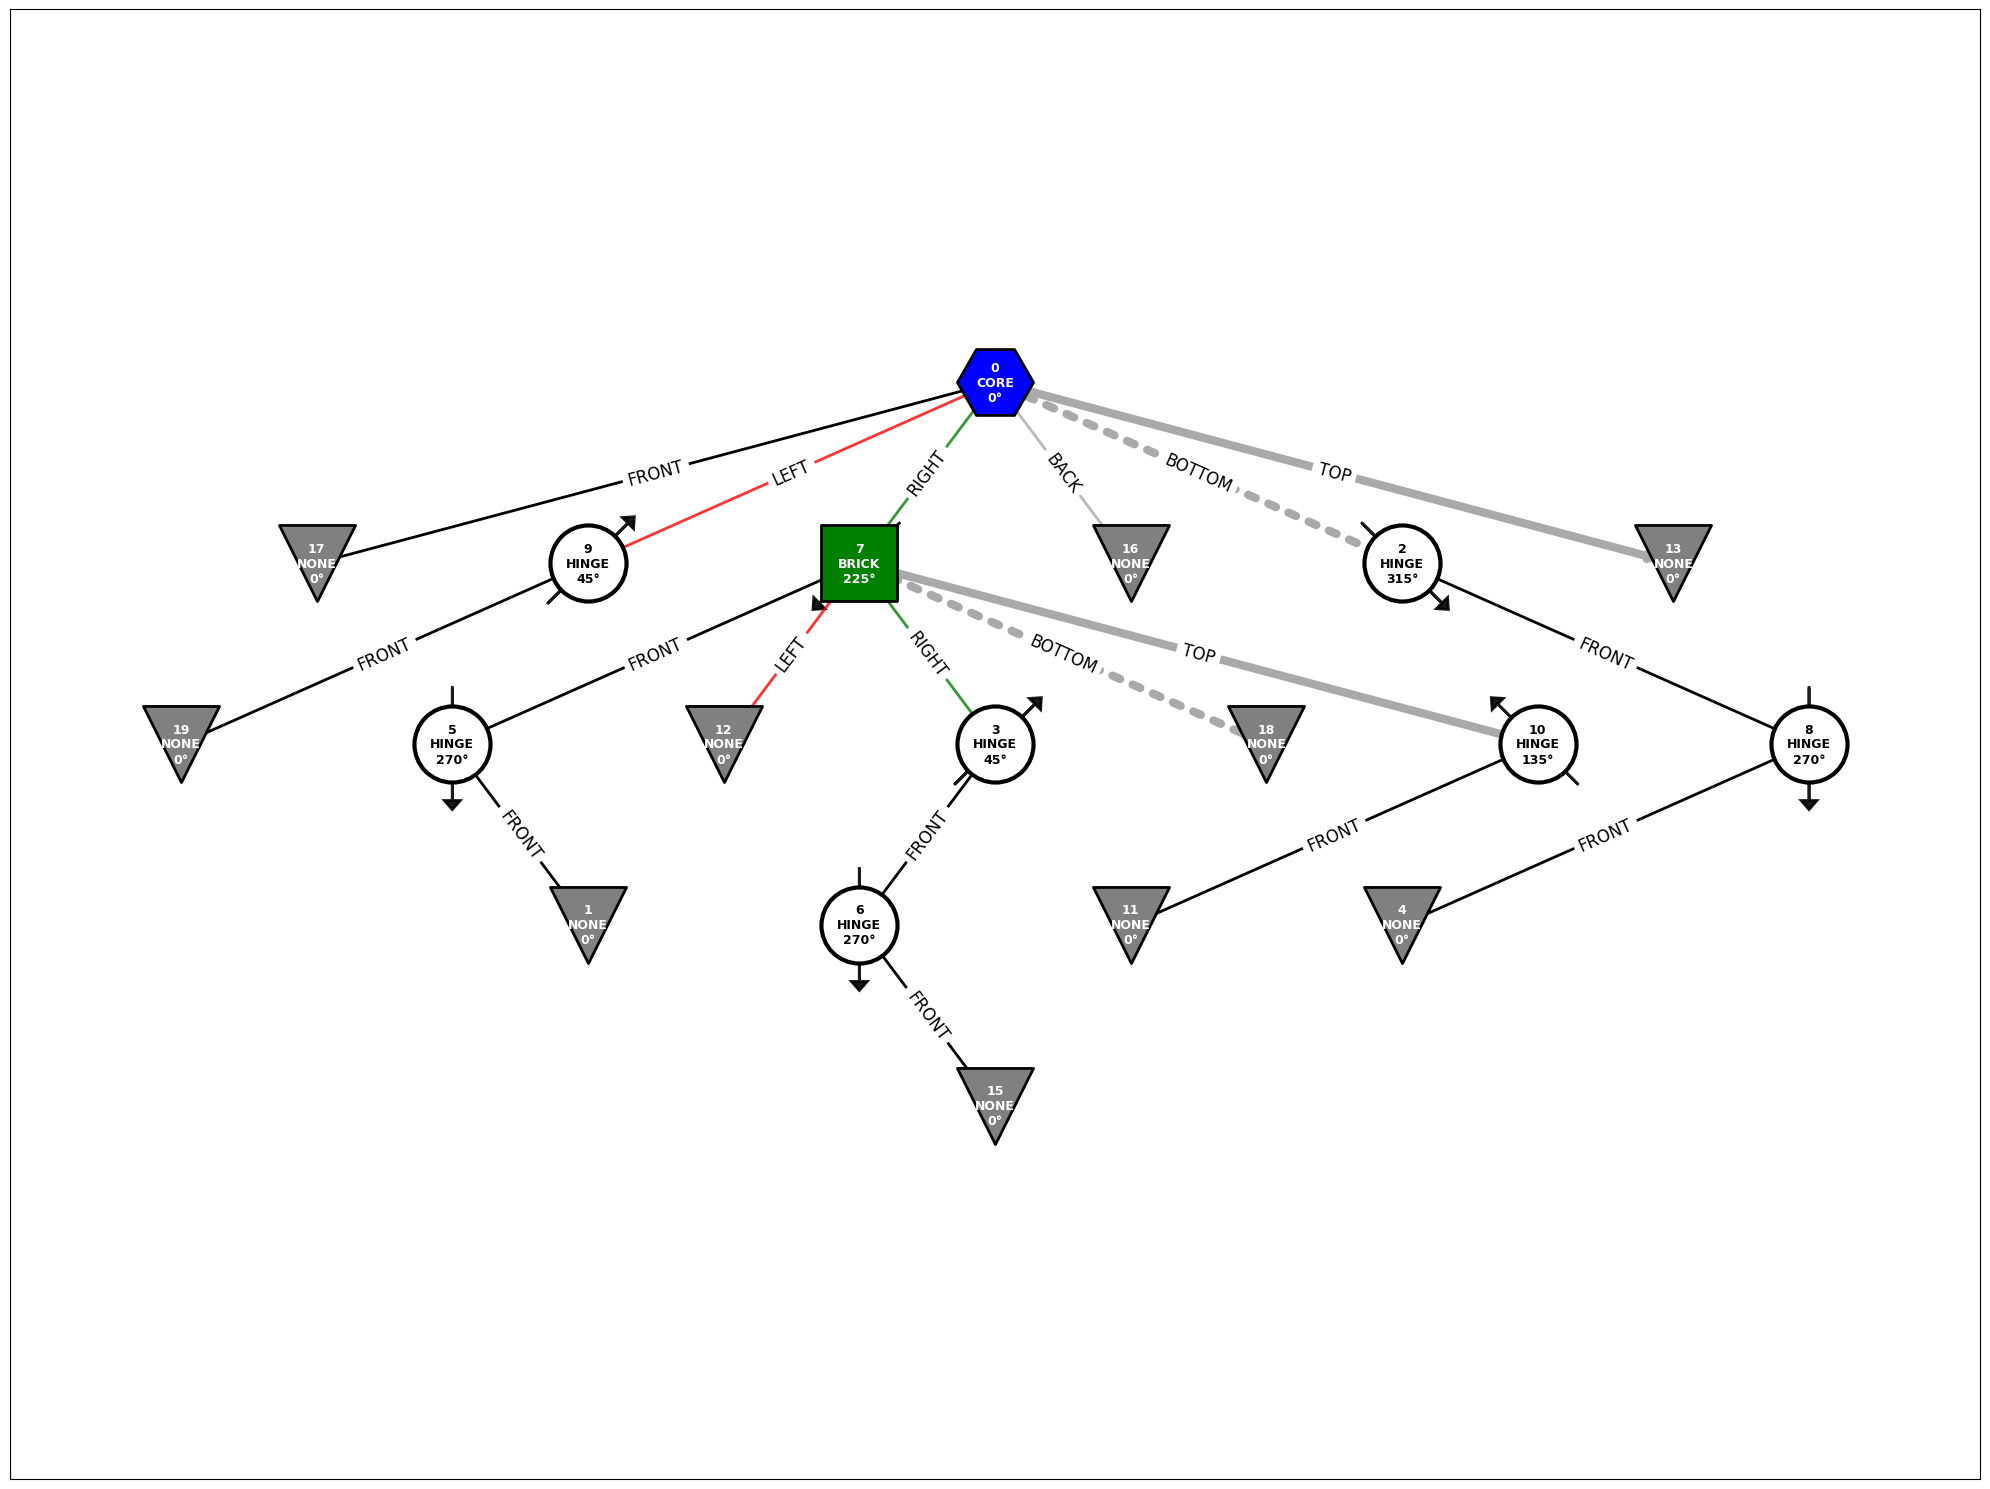

In [79]:
visualizer.visualize_individual()

<!-- The exeperiment shows that the outliers seem to have the same genotype. This leads to the question for how many unique genotypes are actually being created. To run this experiment, a new function should be created that easily parses the given phenotype into a deterministic string. this can than be used in a histogram to count the unique types? -->


The visualizer shows that while the phenotype may be roughly the same, the genotypes are all unique. A new determinstic method needs to be invented to create a 1:1 genotype <-> phenotype canonical mapping.

so going from (many) genotype -> 1 canonical genotype -> 1 phenotype

with this new metric the follownig can be implemented

step 1: normalize the ID's. and check again

---

### To be implemented

In [25]:
def analyze_branching(individual: DiGraph) -> dict[str, float]:
    """
    Measures the level of branching in the robot's morphology (M1).

    Calculation Method: The specific formula for 'Branching' (M1) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    This descriptor is positively correlated with the 'Number of Limbs' [2].
    """
    return {"branching": 0.0}


def analyze_number_of_limbs(individual: DiGraph) -> dict[str, float]:
    """
    Measures the number of effective limbs attached to the robot (M2).

    Calculation Method: The specific formula for 'Number of Limbs' (M2) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    It is used to assess the tendency for morphologies to have few limbs [2, 3].
    """
    return {"number_of_limbs": 0.0}


def analyze_length_of_limbs(individual: DiGraph) -> dict[str, float]:
    """
    Measures the relative length of the limbs (M3).

    Calculation Method: The measure 'Length of Limbs' (E or M3) is defined by the following equation
    (used, for example, in the S3 fitness function as a penalty) [4]:

    E = { e / e_max, if m >= 3
        { 0, otherwise

    Where 'm' is the total number of modules in the body, 'e' is the number of modules
    which have two of their faces attached to other modules (excluding the core-component),
    and 'e_max' is the maximum amount of modules that a body with 'm' modules could have
    with two attached faces, calculated as m - 2 [4].
    A higher value suggests fewer, longer limbs, as it rewards maximizing the length relative to body size [2, 3].
    This descriptor ranges in value from 0 to 1 [1].
    """
    return {"length_of_limbs": 0.0}


def analyze_coverage(individual: DiGraph) -> dict[str, float]:
    """
    Measures how much of the morphology space is covered (M4).

    Calculation Method: The specific formula for 'Coverage' (M4) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    Morphologies similar to snakes (like those predominant under S1 fitness) tended to have high coverage,
    covering the whole body area [5].
    """
    return {"coverage": 0.0}


def analyze_joints(individual: DiGraph) -> dict[str, float]:
    """
    Measures the number of effective joints in the morphology (M5).

    Calculation Method: This descriptor was reformulated for the study.
    The concept of an effective joint is defined by a joint module that is attached to any other module type [1].
    (Previously, attachment was required to be specifically to the core-component or a structural brick [1, 6].)
    This reformulation was done because robots were often observed developing limbs purely formed by a sequence of joints [1].
    The descriptor ranges in value from 0 to 1 [1].
    """
    return {"joints": 0.0}


def analyze_proportion(individual: DiGraph) -> dict[str, float]:
    """
    Measures the proportionality or balance of the robot's shape (M6).

    Calculation Method: The specific formula for 'Proportion' (M6) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    Proportion was observed to drop drastically for fitness S1, which was dominated by single-limb, disproportional robots [5].
    """
    return {"proportion": 0.0}


def analyze_symmetry(individual: DiGraph) -> dict[str, float]:
    """
    Measures the symmetry of the robot's structure (M7).

    Calculation Method: The specific formula for 'Symmetry' (M7) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    Symmetry tended to be higher when a penalty for long limbs (S3 fitness) was applied [7].
    The results suggest that higher symmetry is correlated with lower average speed [8].
    """
    return {"symmetry": 0.0}


def analyze_size(individual: DiGraph) -> dict[str, float]:
    """
    Measures the overall size of the robot's morphology (M8).

    Calculation Method: The specific formula for 'Size' (M8) is not detailed in this source material,
    but it is noted that this descriptor ranges in value from 0 to 1 [1].
    All behavior-oriented searches tended to explore larger Size, as a large body can more easily produce a large displacement for high speed [5].
    """
    return {"size": 0.0}


def analyze_sensors(individual: DiGraph) -> dict[str, float]:
    """
    Measures the ratio of sensors to available slots in the morphology (M9).

    Calculation Method: This is a new descriptor introduced in the study [1]. It is defined by the equation [9]:

    C = { c / c_max, if c_max > 0
        { 0, otherwise

    Where 'c' is the number of sensors in the morphology, and 'c_max' is the number of free slots in the morphology [9].
    The descriptor ranges in value from 0 to 1 [1].
    """
    return {"sensors": 0.0}